In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
from numba import jit
import models as md
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox
from IPython.display import display
import ipywidgets as widgets

# Feedforward inhibition model

In [2]:
@jit
def jit_ffi_model(tau_m, e_l, r_m, stimulus, noise_exc, noise_inh, v_t, dt, total_time, init_vm_std, vt_std, rho_null,
                  tau_inh, rho_scale, init_period):
    ntime_steps = int((total_time+init_period)/dt)
    time_points = np.arange(ntime_steps)*dt
    v_m = np.zeros(ntime_steps)
    v_m[0] = np.random.normal(loc=e_l, scale=init_vm_std)
    v_t = np.random.normal(loc=v_t, scale=vt_std, size=ntime_steps)
    rho_inh = np.zeros(ntime_steps)
    t_spks = []
    idx_spks = []
    # integration:
    t = 1
    while t < ntime_steps:
        # calculate activation of inhibitory population
        rho_inh[t] = rho_inh[t-1] + dt*(rho_null - rho_inh[t-1] + rho_scale*stimulus[t])/tau_inh + noise_inh[t]
        if t%0.01 == 0:
            print(rho_inh[t])
        # calculate lif dynamics with inhibitory input
        v_m[t] = v_m[t - 1] + dt*(- (v_m[t - 1] - e_l) + r_m*stimulus[t] - rho_inh[t-1])/tau_m + noise_exc[t]
        if v_m[t] > v_t[t]:
            v_m[t] = e_l
            if t*dt > init_period:
                t_spks.append(t*dt)
                idx_spks.append(t)
        t = t + 1
    
    return time_points, v_m, t_spks, idx_spks, rho_inh

In [3]:
def calc_response(params):
    # sample lv values uniformly between 0.1 and 1.2
    lv = np.random.rand()*1.1 + 0.1
    # sample stimulus sizes (L) uniformly between 10 and 25
    stim_size = np.random.rand()*15 + 10
    speed = 1/(lv/stim_size)
    t, stims, tstims, dists, t_to_coll, tstim_to_coll = md.transform_stim(stim_size, speed, params['total_time'],
                                                                          params['dt'], params['m'], params['b'],
                                                                          params['init_period'])

    stimulus = tstims*1e-11
    sigma_exc = params['noise_std_exc'] * np.sqrt(params['dt'])
    sigma_inh = params['noise_std_inh'] * np.sqrt(params['dt'])
    noise_exc = np.random.normal(loc=0.0, scale=sigma_exc, size=len(stimulus))
    noise_inh = np.random.normal(loc=0.0, scale=sigma_inh, size=len(stimulus))

    #np.random.seed(1)
    time, v_m, spks, spk_idc, rho_inh = jit_ffi_model(params['tau_m'], params['e_l'], params['r_m'], stimulus, noise_exc,
                                                      noise_inh, params['v_t'], params['dt'], params['total_time'],
                                                      params['init_vm_std'], params['vt_std'], params['rho_null'],
                                                      params['tau_inh'], params['rho_scale'], params['init_period'])
    if not len(spks)==0:
        first_spike = spks[0]
        first_spike_idx = spk_idc[0]
    else:
        first_spike = 0
        first_spike_idx = 0
        
    if not first_spike_idx >= len(t_to_coll):
        resp_in_t_to_coll = t_to_coll[first_spike_idx]
    else:
        resp_in_t_to_coll = 0
        
    return stims[first_spike_idx], dists[first_spike_idx], first_spike, lv, stim_size, speed, resp_in_t_to_coll

In [11]:
def plot_trial(exc_scale=9, inh_scale=9, r_m=10, tau_inh=10, speed_idx=2):
    tau_m = 0.023
    e_l = -0.079
    r_m = r_m*1e6 # MOhm
    v_t = -0.061
    init_vm_std = 0.001
    vt_std = 0.005

    rho_null = 0.010
    tau_inh = tau_inh/1000
    rho_scale = inh_scale*1e6

    dt = 0.001
    total_time = 5
    init_period = 2

    noise_std_exc = 20*1e-3
    noise_std_inh = 5*1e-3
    n_timepoints = int((total_time+init_period)/dt)

    # generate looming stimulus
    LV_vals = np.array([0.19, 0.38, 0.56, 0.74, 0.93, 1.11])
    stim_size = 10
    speeds = 1/(LV_vals/stim_size)
    speed = speeds[speed_idx]
    cutoff_angle = 150

    m = 5.5
    b = 5

    t, stims, tstims, dists, t_to_collision, transformed_stim_to_collision = md.transform_stim(stim_size, speed,
                                                                                               total_time, dt, m,
                                                                                               b, init_period,
                                                                                               cutoff_angle)

    stimulus = tstims*exc_scale*1e-11
    sigma_exc = noise_std_exc * np.sqrt(dt)
    sigma_inh = noise_std_inh * np.sqrt(dt)
    noise_exc = np.random.normal(loc=0.0, scale=sigma_exc, size=n_timepoints)
    noise_inh = np.random.normal(loc=0.0, scale=sigma_inh, size=n_timepoints)
    time, v_m, spks, spk_idc, rho_inh = jit_ffi_model(tau_m, e_l, r_m, stimulus, noise_exc, noise_inh, v_t, dt,
                                                      total_time, init_vm_std, vt_std, rho_null, tau_inh, rho_scale,
                                                      init_period)

    if not len(spks)==0:
        first_spike = spks[0]
        first_spike_idx = spk_idc[0]
    else:
        first_spike = 0
        first_spike_idx = 0

    fig, axes = plt.subplots(5, 1, figsize=(6,12))
    axes[0].plot(time, stims)
    axes[0].set_title(r'stimulus angle [$ \degree $]')
    #axes[0].set_ylim([0, 100])
    axes[1].plot(time, rho_inh)
    axes[1].set_title('inhibitory population activity')
    axes[2].plot(time, stimulus*r_m)
    axes[2].set_title('stimulus*r_m')
    axes[3].plot(time, stimulus*r_m - rho_inh)
    axes[3].set_title('effective input (stimulus + inhibition)')
    axes[4].plot(time, v_m)
    axes[4].set_title('membrane potential')
    if not len(spks) == 0:
        axes[4].plot(spks, np.ones(len(spks))*v_t, 'r*')
    plt.subplots_adjust(hspace=0.5)
    print('Response angle at first spike: ' + str(stims[first_spike_idx]) + ' degree')
    print('Distance at first spike: ' + str(dists[first_spike_idx]) + ' mm')

In [12]:
#parameter sliders
exc_scale_slider = widgets.FloatSlider(min=1, max=200, step=1, value=33, continuous_update=False)
inh_scale_slider = widgets.FloatSlider(min=1, max=20, step=0.2, value=9.6, continuous_update=False)
rm_slider = widgets.FloatSlider(min=1, max=20, step=0.2, value=10, continuous_update=False)
tau_inh_slider = widgets.IntSlider(min=1, max=50, step=2, value=10, continuous_update=False)
speed_idx_slider = widgets.IntSlider(min=0, max=5, step=1, value=2, continuous_update=False)
plotgroup = interactive(plot_trial, exc_scale=exc_scale_slider, inh_scale=inh_scale_slider, r_m=rm_slider,
                        tau_inh=tau_inh_slider, speed_idx=speed_idx_slider)

# refresh button
button = widgets.Button(description='Refresh')
def on_button_clicked(b):
    plotgroup.update()
button.on_click(on_button_clicked)

# combine sliders and button
allgroups = HBox(children=[plotgroup, button])

In [13]:
allgroups

A Jupyter Widget

## One parameter set example

Mean visual angle: 58.6931816498
Mean distance: 17.5086463864
Mean reaction time: 3.292027
resp in ttc: -0.48


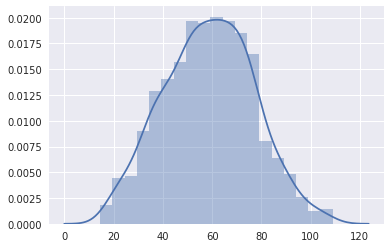

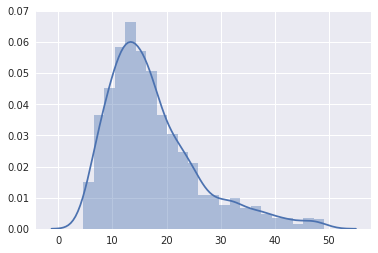

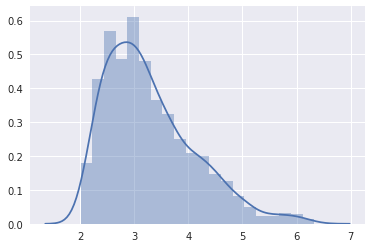

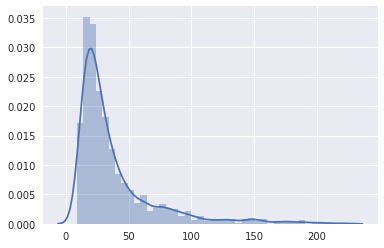

In [7]:
total_time = 5
dt = 0.001

params = {'tau_m': 0.023,
          'e_l': -0.079,
          'r_m': 10*1e6,
          'v_t': -0.061,
          'init_vm_std': 0.001,
          'vt_std': 0.004,
          'rho_null': 0.00,
          'tau_inh': 0.010,
          'rho_scale': 7.6*1e6,
          'dt': dt,
          'total_time': total_time,
          'init_period': 2,
          'noise_std_exc': 5*1e-3,
          'noise_std_inh': 5*1e-3,
          'n_timepoints': int(total_time/dt),
          'cutoff_angle': 150,
          'm': 5,
          'b': 5}

nruns = 1000
rstims = np.zeros(nruns)
rdists = np.zeros(nruns)
reaction_times = np.zeros(nruns)
speeds = np.zeros(nruns)
for i in np.arange(nruns):
    rstims[i], rdists[i], reaction_times[i], lv, stim_size, speeds[i], resp_in_t_to_coll = calc_response(params)

sns.set()
sns.distplot(rstims)
print('Mean visual angle: ' + str(np.mean(rstims)))
plt.figure()
sns.distplot(rdists)
print('Mean distance: ' + str(np.mean(rdists)))
plt.figure()
sns.distplot(reaction_times)
plt.figure()
sns.distplot(speeds)
print('Mean reaction time: ' + str(np.mean(reaction_times)))
print('resp in ttc: ' + str(resp_in_t_to_coll))